#### Stacking - A Meta-Classifier is Applied to Base Models


Stacking is an ensemble learing technique which combines multiple classification models with a meta-classifier. The goal is to improve prediction accuracy by leveraging multiple models.

In this notebook, we stack models which were trained on features engineered using NLP techniques. Logistic Regression is used as the meta-classifier.

Outline
1. Data
1. Machine Learning
    a. Cross Validation
    b. Fit, Predict and Score

##### Prelimiary data acquisition and wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import gc
gc.enable();

C:\Users\pablo\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# read in data
df = pd.read_pickle('capstone2_balanced_withfeatures')

# create a dataframe that contains only the target variable and tokenized url
df_model = df.loc[:,['category', 'tokenized_url']]

In [5]:
# make cateogry values numeric
category = {'benign':1, 'phishing':2, 'malicious':3}
df_model.category = [category[item] for item in df_model.category]

In [6]:
# assemble all tokens
url_tokens = [f'{str(i)}' for i in df['tokenized_url']]

In [7]:
# create new column; frop toeknized_url
df_model['url_tokens'] = url_tokens
df_model = df_model.drop('tokenized_url', axis=1)

In [8]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 6229 to 282723
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   category    30000 non-null  int64 
 1   url_tokens  30000 non-null  object
dtypes: int64(1), object(1)
memory usage: 703.1+ KB


### Machine Learning 

#### Cross Validation

In [9]:
# Specify base & meta classifers. Perform 3-fold cross validation & review cross-val accuracy scores.

from sklearn.model_selection import train_test_split 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

corpus = url_tokens
vectorizer = TfidfVectorizer(lowercase=False)
X = vectorizer.fit_transform(corpus)
y = df_model['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf1 = LogisticRegression(C = 100)
clf2 = RandomForestClassifier(max_depth=None, max_features = 30, n_estimators = 1000)
clf3 = LinearSVC(C = 1, penalty =  'l2')

lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['Logistic Regression', 'Random Forest Classifier', 
                       'LinearSVC', 'Stacking Classifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    

3-fold cross validation:

Accuracy: 0.96 (+/- 0.00) [Logistic Regression]
Accuracy: 0.96 (+/- 0.00) [Random Forest Classifier]
Accuracy: 0.96 (+/- 0.00) [LinearSVC]
Accuracy: 0.96 (+/- 0.00) [Stacking Classifier]


#### Fit, Predict and Score

In [10]:
sclf.fit(X_train, y_train)

predictions = sclf.predict(X_test)
acc = accuracy_score(y_test, predictions)
print("Accuracy: {:.4%}".format(acc))

Accuracy: 96.3333%



Accuracy: 0.9633

Micro Precision: 0.9633
Micro Recall: 0.9633
Micro F1-score: 0.9633

Macro Precision: 0.9642
Macro Recall: 0.9633
Macro F1-score: 0.9634

Weighted Precision: 0.9642
Weighted Recall: 0.9633
Weighted F1-score: 0.9635

Classification Report

              precision    recall  f1-score   support

      Benign     0.9879    0.9805    0.9842      2002
    Phishing     0.9250    0.9699    0.9469      1996
   Malicious     0.9797    0.9396    0.9592      2002

    accuracy                         0.9633      6000
   macro avg     0.9642    0.9633    0.9634      6000
weighted avg     0.9642    0.9633    0.9635      6000



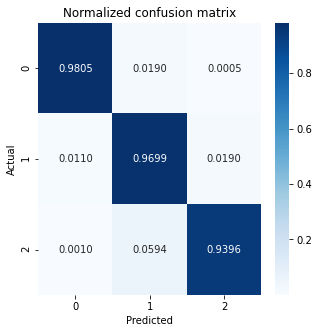

In [11]:
# print scores

print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, predictions)))

print('Micro Precision: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_test, predictions, average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_test, predictions, average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_test, predictions, average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_test, predictions, average='macro')))

print('Weighted Precision: {:.4f}'.format(precision_score(y_test, predictions, average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_test, predictions, average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_test, predictions, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, predictions, target_names=['Benign', 'Phishing', 'Malicious'], digits=4))
    
# Plot and display confusion matrix
cm = confusion_matrix(y_test, predictions, normalize='true')
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, cmap=plt.cm.Blues, annot=True, fmt='.4f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Normalized confusion matrix")
plt.show(block=False)
